# <h1><center>Q-learning Tutorial</center></h1>

This notebook provides an introductory tutorial to Q-learning. Specifically, we will implement Q-Learning using a Q-table in JAX and use it to steer a simplified brittle star robot towards a random target. The [brittle star robot and its environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star) is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb). Instead of directly outputting joint-level actions, we will use our Q-learned controller to modulate a CPG that in turn outputs the joint-level actions.


## Q-Learning

* Belongs to the class of model-free algorithms, meaning that it does not require prior knowledge (or a model) of the environment.
* Is an off-policy algorithm, meaning that it does not necessarily use the 'current policy' to produce actions
* As it name entails, the goal of the algorithm is to learn the Q-function
    * The Q-function receives state and action pairs, and (tries to) return the expected cumulative reward
        * In other words, it tries to predict the expected payoff of doing a certain action in a given state
* In this tutorial we will focus on tabular Q-learning
    * We will optimize the values of a two-dimensional table with states as rows and actions as columns.
    * Each cell in this table corresponds to the Q value of a state and action
        * As we use a table, the state and actions have to be discretized.
    * Initially, this Q-table will be populated with arbitrary values or zeros
    * The q-learning algorithm then tries to optimize the values in this table through an iterative process of exploration and exploitation.
        * During the exploration phase, the agent will take random actions to gather information about the environment and update the Q-table accordingly
        * As the agent explores more, it gradually transitions to the exploitation phase, where it leverages the learned Q-values to make more informed decisions and maximize the cumulative reward
    * The Q-learning algorithm can be summarized as follows:
        1. Initialize the Q-table with arbitrary values or zeros
        2. Observe the current state of the environment
        3. Choose an action to take based on a exploration-exploitation trade-off. This can for instance be done by using an exploration strategy like epsilon-greedy, where the agent selects a random action with a certain probability and chooses the action with the highest Q-value with a complementary probability.
        4. Perform the chosen action and observe the reward and the resulting next state
        5. Update the Q-value of the state-action pair using the Q-learning update rule:<br>
        $Q(s,a) = (1 - \alpha) Q(s,a) + \alpha(r + \gamma\max(Q(s', a')))$<br>
                where alpha $\alpha$ is the learning rate, gamma $\gamma$ is the discount factor that determines the importance of future rewards, $r$ is the immediate reward obtained (given by the environment), and $\max(Q(s', a'))$ represents the maximum Q-value for the next state. 
        6. Repeat steps $2$ to $5$ until convergence or a predefined number of iterations.
* A natural extension of the tabular Q-learning algorithm is the Deep-QLearning (DQN) algorithm. As it name gives away, the DQN algorithm swaps the Q-table for a deep Q-neural-network. This neural network maps states to Q(s, a) values. 

* This tutorial will focus on Q-Table learning 

## Implementing tabular Q-learning in JAX

When implementing something in JAX it's important to remember that JAX follows the functional programming paradigm. Put simply, we thus rely on pure functions (deterministic and without side effects) and immutable data structures (instead of changing data in place, new data structures are created with the desired modifications) as primary building blocks.

We will thus start by creating a data structure that we will use to hold our current Q-Learner's state and its related learning (hyper)parameters.

In [2]:
import random

import gymnasium
from flax import struct
import jax
import jax.numpy as jnp


@struct.dataclass
class QLearnerState:
    q_table: jnp.ndarray
    alpha: float
    epsilon: float
    gamma: float


def initialize_q_learning_state(
        num_states: int,
        num_actions: int,
        alpha: float,
        epsilon: float,
        gamma: float,
        rng: jnp.ndarray
        ) -> QLearnerState:
    # noinspection PyArgumentList
    return QLearnerState(
            q_table=jax.random.uniform(
                    key=rng, shape=(num_states, num_actions), dtype=jnp.float32, minval=-0.001, maxval=0.001
                    ), alpha=alpha, epsilon=epsilon, gamma=gamma
            )

The `QLearnerState` will be the main data structure that we'll pass around between functions.
Next, we can implement a function that receives the current `QLearnerState`, an environment state index (which represents the environment's state in a discretized manner), an action index, and a reward, and in turn returns an updated `QLearnerState` after applying the Q-learning update rule. 

In [70]:
@jax.jit
def apply_q_learning_update_rule(
        q_learner_state: QLearnerState,
        state_index: int,
        next_state_index: int,
        action_index: int,
        reward: float
        ) -> QLearnerState:
    old_q_value = q_learner_state.q_table[state_index, action_index]
    best_future_q_value = jnp.max(q_learner_state.q_table[next_state_index])
    q_value_update = reward + q_learner_state.gamma * best_future_q_value
    new_q_value = (1 - q_learner_state.alpha) * old_q_value + q_learner_state.alpha * q_value_update

    new_q_table = q_learner_state.q_table.at[state_index, action_index].set(new_q_value)
    return q_learner_state.replace(q_table=new_q_table)

Next, we can implement a function that represents our policy. This function will receive the current `QLeanerState`, uses the epsilon-greedy strategy to handle the trade-off between exploration and exploitation, and returns an action index.

In [71]:
@jax.jit
def epsilon_greedy_policy(
        q_learner_state: QLearnerState,
        rng: jnp.ndarray,
        state_index: int
        ) -> int:
    explore_rng, random_action_rng = jax.random.split(rng, 2)
    explore = jax.random.uniform(explore_rng) < q_learner_state.epsilon

    def get_random_action() -> int:
        return jax.random.choice(key=random_action_rng, a=jnp.arange(q_learner_state.q_table.shape[1]))

    def get_greedy_action() -> int:
        return jnp.argmax(q_learner_state.q_table[state_index])

    action_index = jax.lax.cond(
            pred=explore, true_fun=get_random_action, false_fun=get_greedy_action
            )

    return action_index

A general training loop:

In [72]:
from typing import Any, Callable, Dict, Tuple
from tqdm import tqdm
from mujoco_utils.environment.mjx_env import MJXGymEnvWrapper

ActionMapperState = Any


def train_q_learning_agent(
        q_learner_state: QLearnerState,
        num_episodes: int,
        env: MJXGymEnvWrapper,
        state_indexer: Callable[[Dict[str, jnp.ndarray]], int],
        action_mapper: Callable[[ActionMapperState, int], Tuple[ActionMapperState, jnp.ndarray]],
        action_mapper_state: ActionMapperState,
        rng: jnp.ndarray
        ) -> QLearnerState:


    for _ in tqdm(range(num_episodes)):
        obs, info = env.reset()
        state_index = state_indexer(obs)

        done = False
        while not done:
            rng, action_rng = jax.random.split(rng, 2)

            action_index = epsilon_greedy_policy(
                    q_learner_state=q_learner_state, rng=action_rng, state_index=state_index
                    )
            action_mapper_state, actions = action_mapper(action_mapper_state, action_index)
            obs, reward, terminated, truncated, info = env.step(actions=actions)

            new_state_index = state_indexer(obs)
            q_learner_state = apply_q_learning_update_rule(
                    q_learner_state=q_learner_state,
                    state_index=state_index,
                    next_state_index=new_state_index,
                    action_index=action_index,
                    reward=reward
                    )

            done = jnp.any(terminated | truncated)
            state_index = new_state_index

    return q_learner_state

We can also create a general evaluation loop that we can use later to visualize our learned policy:

In [63]:
import numpy as np
from typing import List


def visualize_q_learning_agent(
        q_learner_state: QLearnerState,
        env: MJXGymEnvWrapper,
        state_indexer: Callable[[Dict[str, jnp.ndarray]], int],
        action_mapper: Callable[[int], jnp.ndarray], ) -> List[np.ndarray]:
    obs, info = env.reset()

    # noinspection PyUnresolvedReferences
    #   no more random actions
    q_learner_state = q_learner_state.replace(epsilon=0)
    action_rng = jax.random.PRNGKey(0)

    frames = []
    done = False
    while not done:
        state_index = state_indexer(obs)

        action_index = epsilon_greedy_policy(
                q_learner_state=q_learner_state, rng=action_rng, state_index=state_index
                )
        actions = action_mapper(action_index)
        obs, reward, terminated, truncated, info = env.step(actions=actions)

        frames.append(env.render())
        done = jnp.any(terminated | truncated)

    return frames

TODO: visualize QTable

Great, we have implemented the tabular Q-learning algorithm. Time to test it out with the brittle star environment!

## Case study: CPG modulations for directed brittle star locomotion

### Environment setup
* Load BRB's brittle star environment -> targeted locomotion
* Create a state indexer
* Create an action mapper 

In [16]:
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from typing import Union
import mediapy as media
from brb.brittle_star.environment.target.mjx_env import BrittleStarTargetMJXEnvironment
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena
from brb.brittle_star.environment.target.mjc_env import BrittleStarTargetEnvironmentConfiguration

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=5, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=False, attach_target=True, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarTargetEnvironmentConfiguration(
        # Distance to put our target at (targets are spawned on a circle around the starting location with this given radius).
        target_distance=3.0,
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=10,
        num_physics_steps_per_control_step=10,
        camera_ids=[0, 1]
        )


def create_environment(
        num_environments: int = 1
        ) -> MJXGymEnvWrapper:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    env = BrittleStarTargetMJXEnvironment(morphology=morphology, arena=arena, configuration=environment_configuration)
    return MJXGymEnvWrapper(env=env, num_envs=num_environments)


def post_environment_render(
        render_output: Union[np.ndarray, List[np.ndarray]], ) -> np.ndarray:
    if len(environment_configuration.camera_ids) > 1:
        render_output = np.concatenate(render_output, axis=1)

    return render_output[:, :, ::-1]  # RGB to BGR

Observation space:
Dict('disk_angular_velocity': Box(-inf, inf, (3,), float32), 'disk_linear_velocity': Box(-inf, inf, (3,), float32), 'disk_position': Box(-inf, inf, (3,), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (4,), float32), 'in_plane_joint_velocity': Box(-inf, inf, (4,), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (4,), float32), 'out_of_plane_joint_velocity': Box(-inf, inf, (4,), float32), 'segment_contact': Box(0.0, 1.0, (4,), float32), 'unit_xy_direction_to_target': Box(-1.0, 1.0, (2,), float32), 'xy_distance_to_target': Box(0.0, inf, (1,), float32))

Action space:
Box(-0.5235988, 0.5235988, (8,), float32)


""

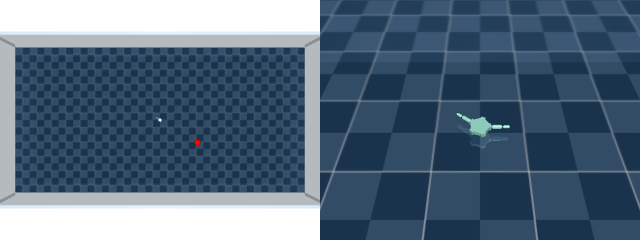

In [8]:
env = create_environment(num_environments=1)
print("Observation space:")
print(env.observation_space)
print()
print("Action space:")
print(env.action_space)
env.reset()
media.show_image(post_environment_render(env.render()))
env.close()

### CPG setup

* CPG model from Sproewitz paper
* Oscillator system from the CPG tutorial

Copied CPG implementation from the CPG tutorial:

In [73]:
from functools import partial
from flax import struct
import jax
import jax.numpy as jnp


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray


@struct.dataclass
class CPGConstants:
    num_oscillators: int
    amplitude_gain: float
    offset_gain: float
    weights: jnp.ndarray
    dt: float


@struct.dataclass
class CPGModulators:
    R: jnp.ndarray
    X: jnp.ndarray
    omegas: jnp.ndarray
    rhos: jnp.ndarray


@struct.dataclass
class CPG:
    state: CPGState
    constants: CPGConstants
    modulators: CPGModulators


def phase_de(
        weights: jnp.ndarray,
        amplitudes: jnp.ndarray,
        phases: jnp.ndarray,
        phase_biases: jnp.ndarray,
        omegas: jnp.ndarray
        ) -> jnp.ndarray:
    @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
    def sine_term(
            phase_i: float,
            phase_biases_i: float
            ) -> jnp.ndarray:
        return jnp.sin(phases - phase_i - phase_biases_i)

    couplings = jnp.sum(weights * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
    return omegas + couplings


def second_order_de(
        gain: jnp.ndarray,
        modulator: jnp.ndarray,
        values: jnp.ndarray,
        dot_values: jnp.ndarray
        ) -> jnp.ndarray:
    return gain * ((gain / 4) * (modulator - values) - dot_values)


def first_order_de(
        dot_values: jnp.ndarray
        ) -> jnp.ndarray:
    return dot_values


def output(
        offsets: jnp.ndarray,
        amplitudes: jnp.ndarray,
        phases: jnp.ndarray
        ) -> jnp.ndarray:
    return offsets + amplitudes * jnp.cos(phases)


@partial(jax.jit, static_argnums=(1,))
def step_cpg(
        cpg: CPG,
        solver: Callable
        ) -> CPGState:
    # Update phase
    new_phases = solver(
            current_time=cpg.state.time,
            y=cpg.state.phases,
            derivative_fn=lambda
                t,
                y: phase_de(
                    omegas=cpg.modulators.omegas,
                    amplitudes=cpg.state.amplitudes,
                    phases=y,
                    phase_biases=cpg.modulators.rhos,
                    weights=cpg.constants.weights
                    ),
            delta_time=cpg.constants.dt
            )
    new_dot_amplitudes = solver(
            current_time=cpg.state.time,
            y=cpg.state.dot_amplitudes,
            derivative_fn=lambda
                t,
                y: second_order_de(
                    gain=cpg.constants.amplitude_gain,
                    modulator=cpg.modulators.R,
                    values=cpg.state.amplitudes,
                    dot_values=y
                    ),
            delta_time=cpg.constants.dt
            )
    new_amplitudes = solver(
            current_time=cpg.state.time,
            y=cpg.state.amplitudes,
            derivative_fn=lambda
                t,
                y: first_order_de(dot_values=cpg.state.dot_amplitudes),
            delta_time=cpg.constants.dt
            )
    new_dot_offsets = solver(
            current_time=cpg.state.time,
            y=cpg.state.dot_offsets,
            derivative_fn=lambda
                t,
                y: second_order_de(
                    gain=cpg.constants.offset_gain, modulator=cpg.modulators.X, values=cpg.state.offsets, dot_values=y
                    ),
            delta_time=cpg.constants.dt
            )
    new_offsets = solver(
            current_time=0,
            y=cpg.state.offsets,
            derivative_fn=lambda
                t,
                y: first_order_de(dot_values=cpg.state.dot_offsets),
            delta_time=cpg.constants.dt
            )

    new_outputs = output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
    # noinspection PyUnresolvedReferences
    return cpg.replace(
            state=cpg.state.replace(
                    phases=new_phases,
                    dot_amplitudes=new_dot_amplitudes,
                    amplitudes=new_amplitudes,
                    dot_offsets=new_dot_offsets,
                    offsets=new_offsets,
                    outputs=new_outputs,
                    time=cpg.state.time + cpg.constants.dt
                    )
            )


def get_random_initial_cpg_state(
        rng: jnp.ndarray,
        cpg_constants: CPGConstants
        ) -> CPGState:
    phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
    # noinspection PyArgumentList
    state = CPGState(
            phases=jax.random.uniform(
                    key=phase_rng,
                    shape=(cpg_constants.num_oscillators,),
                    dtype=jnp.float32,
                    minval=-jnp.pi,
                    maxval=jnp.pi
                    ),
            amplitudes=jnp.zeros(cpg_constants.num_oscillators),
            offsets=jnp.zeros(cpg_constants.num_oscillators),
            dot_amplitudes=jnp.zeros(cpg_constants.num_oscillators),
            dot_offsets=jnp.zeros(cpg_constants.num_oscillators),
            outputs=jnp.zeros(cpg_constants.num_oscillators),
            time=0.0
            )
    return state


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y

Helper function to create our CPG system:

In [91]:
def create_cpg(
        rng: jnp.ndarray
        ) -> CPG:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    adjacency_matrix = jnp.zeros((10, 10))
    # Connect oscillators within an arm
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)
    # Connect IP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[
        ip_oscillator_indices, jnp.concatenate((ip_oscillator_indices[1:], jnp.array([ip_oscillator_indices[0]])))].set(
            1
            )
    # Connect OOP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[oop_oscillator_indices, jnp.concatenate(
            (oop_oscillator_indices[1:], jnp.array([oop_oscillator_indices[0]]))
            )].set(1)

    # Make adjacency matrix symmetric (i.e. make all connections bi-directional)
    adjacency_matrix = jnp.maximum(adjacency_matrix, adjacency_matrix.T)
    # Connect oscillators within an arm
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)

    # We will overwrite this in our modulation later!
    rhos = jnp.zeros_like(adjacency_matrix, dtype=jnp.float32)

    # noinspection PyArgumentList
    cpg_constants = CPGConstants(
            num_oscillators=10,
            amplitude_gain=20,
            offset_gain=20,
            weights=5 * adjacency_matrix,
            dt=environment_configuration.control_timestep
            )

    cpg_state = get_random_initial_cpg_state(rng=rng, cpg_constants=cpg_constants)
    # noinspection PyArgumentList
    cpg_modulators = CPGModulators(
            R=jnp.zeros(cpg_constants.num_oscillators),
            X=jnp.zeros(cpg_constants.num_oscillators),
            omegas=jnp.pi * jnp.ones(cpg_constants.num_oscillators),
            rhos=rhos
            )
    # noinspection PyArgumentList
    cpg = CPG(
            state=cpg_state, constants=cpg_constants, modulators=cpg_modulators
            )
    return cpg


from typing import Tuple


def get_oscillator_indices_for_arm(
        arm_index: int
        ) -> Tuple[int, int]:
    return arm_index * 2, arm_index * 2 + 1


def modulate_cpg(
        cpg: CPG,
        leading_arm_index: int,
        joint_limit: float, 
        ) -> CPG:
    left_rower_arm_indices = [(leading_arm_index - 1) % 5, (leading_arm_index - 2) % 5]
    right_rower_arm_indices = [(leading_arm_index + 1) % 5, (leading_arm_index + 2) % 5]

    leading_arm_ip_oscillator_index, leading_arm_oop_oscillator_index = get_oscillator_indices_for_arm(
            arm_index=leading_arm_index
            )

    R = jnp.zeros(cpg.constants.num_oscillators)
    X = jnp.zeros(cpg.constants.num_oscillators)
    omegas = cpg.modulators.omegas
    rhos = jnp.zeros_like(cpg.modulators.rhos)

    phases_bias_pairs = []

    for arm_index in range(5):
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=arm_index)

        if arm_index == leading_arm_index:
            X = X.at[oop_oscillator_index].set(joint_limit)
        else:
            R = R.at[ip_oscillator_index].set(joint_limit)
            R = R.at[oop_oscillator_index].set(joint_limit)

            if arm_index in left_rower_arm_indices:
                phases_bias_pairs.append((ip_oscillator_index, oop_oscillator_index, jnp.pi / 2))

                if arm_index == left_rower_arm_indices[0]:
                    phases_bias_pairs.append((ip_oscillator_index, leading_arm_ip_oscillator_index, jnp.pi / 4))
                    phases_bias_pairs.append((leading_arm_oop_oscillator_index, oop_oscillator_index, jnp.pi / 4))
            else:
                phases_bias_pairs.append((oop_oscillator_index, ip_oscillator_index, jnp.pi / 2))

                if arm_index == right_rower_arm_indices[0]:
                    phases_bias_pairs.append((leading_arm_ip_oscillator_index, ip_oscillator_index, jnp.pi / 4))
                    phases_bias_pairs.append((oop_oscillator_index, leading_arm_oop_oscillator_index, jnp.pi / 4))

    # Handle the coupling between the second arm's oscillator ond the left and right of the leading arm
    #   Make the IP oscillators run in anti phase
    left_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=left_rower_arm_indices[1])
    right_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=right_rower_arm_indices[1])
    phases_bias_pairs.append((left_ip_oscillator_index, right_ip_oscillator_index, jnp.pi))

    for oscillator1, oscillator2, bias in phases_bias_pairs:
        rhos = rhos.at[oscillator1, oscillator2].set(bias)
        rhos = rhos.at[oscillator2, oscillator1].set(-bias)

    # noinspection PyArgumentList
    new_modulators = CPGModulators(
            R=R, X=X, omegas=omegas, rhos=rhos
            )
    # noinspection PyUnresolvedReferences
    return cpg.replace(modulators=new_modulators)


def map_cpg_outputs_to_actions(
        cpg: CPG
        ) -> jnp.ndarray:
    num_arms = morphology_specification.number_of_arms
    num_oscillators_per_arm = 2
    num_segments_per_arm = morphology_specification.number_of_segments_per_arm[0]

    cpg_outputs_per_arm = cpg.state.outputs.reshape((num_arms, num_oscillators_per_arm))
    cpg_outputs_per_segment = cpg_outputs_per_arm.repeat(num_segments_per_arm, axis=0)

    actions = cpg_outputs_per_segment.flatten()
    return actions

Implement the action mapper: in this case our `action_index` is the leading arm for our CPG modulation.

In [92]:
def cpg_action_mapper(
        cpg: CPG,
        action_index: int,
        joint_limit: float
        ) -> Tuple[CPG, jnp.ndarray]:
    cpg = modulate_cpg(cpg=cpg, leading_arm_index=action_index, joint_limit=joint_limit)
    cpg = step_cpg(cpg=cpg, solver=euler_solver)
    actions = map_cpg_outputs_to_actions(cpg=cpg)
    return cpg, actions

Implement the state indexer. In this case, we will only use the `unit_xy_direction_to_target` observation. We'll convert this into an actual angle w.r.t. the robot's orientation and descretize it in 5 areas (one per arm).

In [89]:
@jax.jit
def state_indexer(
        observations: Dict[str, jnp.ndarray]
        ) -> int:
    direction_to_target = observations["unit_xy_direction_to_target"]
    angle_to_target_wrt_x_axis = jnp.arctan2(direction_to_target[1], direction_to_target[0])
    disk_rotation_wrt_x_axis = observations["disk_rotation"][-1]

    angle_to_target_wrt_first_arm = angle_to_target_wrt_x_axis - disk_rotation_wrt_x_axis

    num_arms = morphology_specification.number_of_arms
    a = jnp.pi / num_arms
    bin_edges = jnp.arange(-num_arms * a, (num_arms + 1) * a, 2 * a)
    bin_index = jnp.digitize(angle_to_target_wrt_first_arm, bin_edges, right=False) - 1
    bin_index_to_arm_index = jnp.array([3, 4, 0, 1, 2])

    return bin_index_to_arm_index[bin_index]

In [18]:
env = create_environment(1)

In [87]:
obs, info = env.reset()

0.5235988

""

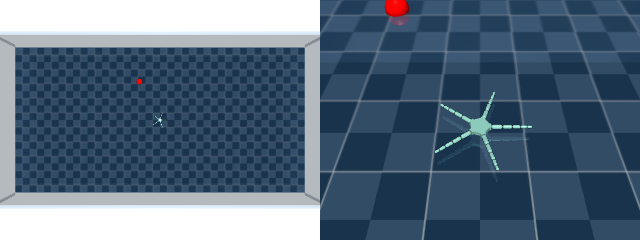

In [51]:
media.show_image(post_environment_render(env.render()))
media.write_image("image.png", post_environment_render(env.render()))

In [78]:
rng = jax.random.PRNGKey(seed=0)
rng, q_learner_rng, cpg_rng, train_rng = jax.random.split(rng, 4)

q_learner_state = initialize_q_learning_state(
        num_states=morphology_specification.number_of_arms,
        num_actions=morphology_specification.number_of_arms,
        alpha=0.1,
        epsilon=0.3,
        gamma=0.99,
        rng=q_learner_rng
        )
cpg = create_cpg(rng=cpg_rng)

In [93]:
trained_q_learner_state = train_q_learning_agent(
        q_learner_state=q_learner_state,
        num_episodes=1000,
        env=env,
        state_indexer=state_indexer,
        action_mapper=partial(cpg_action_mapper, joint_limit=env.action_space.high[0]),
        action_mapper_state=cpg,
        rng=train_rng
        )

  1%|          | 6/1000 [02:25<6:42:37, 24.30s/it]


KeyboardInterrupt: 

5000

In [17]:
env.close()

### Exploit JAX: vectorize!
Todo: compare training times

## Exercise
* Reduce the epsilon over time
* Make the controller decentralized
    * You'll need to make the states and actions arm specific
    * E.g. like this:
        * Actions = [leading arm, left rower, right rower]
                * Or: [amplitude 0, amplitude 0.5, amplitude 1]
        * State = [arm is closest to target, arm is on left axis, arm is on right axis]
        * You'll have to modify the CPG as well!